## Import libraries

In [172]:
import pandas as panda
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

from sklearn import linear_model
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, plot_confusion_matrix

from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.preprocessing import StandardScaler, normalize

In [173]:
panda.set_option("display.max_columns", 57)

columns = []
with open("columns.txt", "r") as doc:
    lines = doc.readlines()
    for line in lines:
        columns.append(line.split(":")[0])

In [174]:
df2 = panda.read_csv("spambase.data", header=None)

## Data preprocessing. Training and test set

In [175]:
y = df2[np.shape(df2)[1]-1] # class column
x = df2.drop([np.shape(df2)[1]-1], axis = 1) # remove class column

In [176]:
scaler = StandardScaler()
x = panda.DataFrame(scaler.fit_transform(x))

In [177]:
# x = panda.DataFrame(normalize(x_original))

### Normalization worsen the quality of data

In [178]:
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=69, train_size=0.66)

## Initialize models

In [179]:
MODELS = []
MODELS.append(("Logistig Regression", LogisticRegression(max_iter=10000)))
MODELS.append(("Decision Tree Classifier", DecisionTreeClassifier()))
MODELS.append(("SVC", SVC()))
MODELS.append(("K Nearest Neighbour", KNeighborsClassifier()))
MODELS.append(("Support Vector Classification", SVC()))
MODELS.append(("Stochastic Gradient Descent", SGDClassifier()))
MODELS.append(("Linear Discriminant Analysis", LinearDiscriminantAnalysis()))
MODELS.append(("Gradient Boosting Classification ", GradientBoostingClassifier()))
MODELS.append(("Random Forest Classification", RandomForestClassifier()))

In [180]:
def get_stats(y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted)
    recall = recall_score(y_test, y_predicted)
    f1 = f1_score(y_test, y_predicted)
    roc = roc_auc_score(y_test, y_predicted)
    return [accuracy,precision,recall,f1,roc]


### Fit train data in model and predict

In [181]:
column_names = ["Model","Accuracy", "Precision","Recall","F1-Score","AUC"]
results = []
for name, model in MODELS:
    model.fit(X=x_train, y=y_train)
    y_predicted = model.predict(x_test)
    results.append([name, *get_stats(y_predicted)])

## Create dataframe and sort

In [182]:
res = panda.DataFrame(results, columns=column_names)
res = res.sort_values(by="Accuracy", ascending=False)
res

,Model,Accuracy,Precision,Recall,F1-Score,AUC
8,Random Forest Classification,0.952077,0.955224,0.923077,0.938875,0.947192
7,Gradient Boosting Classification,0.944409,0.948247,0.910256,0.928863,0.938656
2,SVC,0.916933,0.930314,0.855769,0.891486,0.906631
4,Support Vector Classification,0.916933,0.930314,0.855769,0.891486,0.906631
0,Logistig Regression,0.913738,0.925217,0.852564,0.887406,0.903434
1,Decision Tree Classifier,0.909904,0.892683,0.879808,0.886199,0.904835
3,K Nearest Neighbour,0.891374,0.887372,0.833333,0.859504,0.881598
5,Stochastic Gradient Descent,0.885623,0.854864,0.858974,0.856914,0.881134
6,Linear Discriminant Analysis,0.872843,0.917485,0.748397,0.824360,0.851882


### Sort the initial models by precision

In [183]:
diz = {v: i for i, v in enumerate(list(res["Model"]))}
SORTED_MODELS = sorted(MODELS, key = lambda x: diz[x[0]])

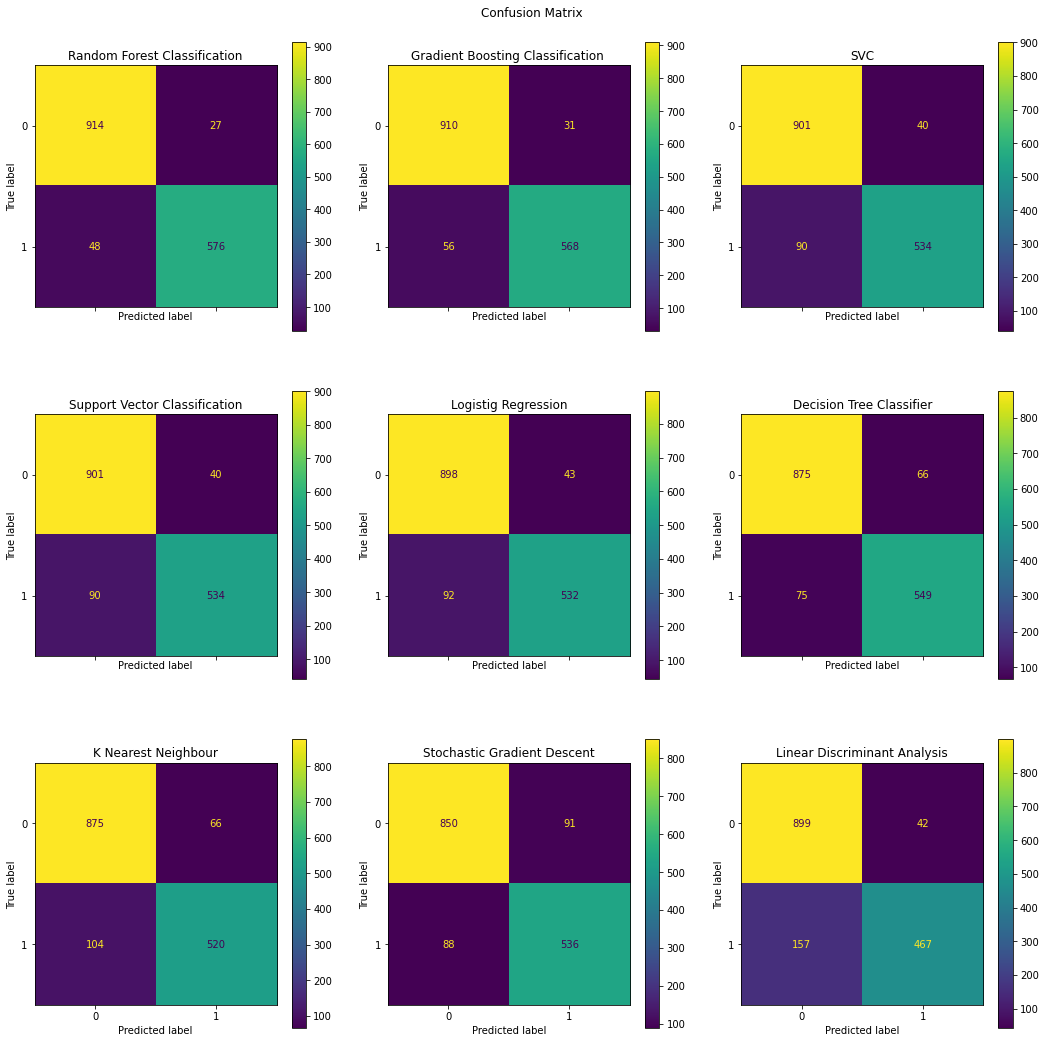

In [184]:
items_per_row = 3
fig, axs = plt.subplots(ceil(len(SORTED_MODELS)/items_per_row), items_per_row, sharex=True, figsize=(15,15))
fig.suptitle('Confusion Matrix')
fig.tight_layout(pad=2.0, h_pad=5.0)

for i, (name, model) in enumerate(SORTED_MODELS):
    y,x = i // items_per_row, i % items_per_row
    plot_confusion_matrix(model, x_test, y_test, ax=axs[y,x])
    axs[y,x].set_title(name)

for i in range(len(SORTED_MODELS),ceil(len(SORTED_MODELS)/items_per_row) * items_per_row):
    y,x = i // items_per_row, i % items_per_row
    axs[y,x].axis("off")
